In [1]:
# --- FIX LỖI MÔI TRƯỜNG KAGGLE ---
# Lệnh này sẽ chạy trên server Kaggle để gỡ thư viện gây xung đột
import os

# Gỡ bỏ Cupy (thủ phạm chính gây xung đột với Spacy/Scipy hiện tại)
os.system("pip uninstall -y cupy cupy-cuda11x cupy-cuda12x")

# Cài đặt lại Numpy và Scipy bản ổn định để tránh lỗi "ufunc"
os.system("pip install 'numpy<2.0' 'scipy<1.13'")

# --- KẾT THÚC FIX LỖI ---
print("Đã sửa xong môi trường! Bắt đầu chạy code chính...")

Found existing installation: cupy-cuda12x 13.6.0
Uninstalling cupy-cuda12x-13.6.0:
  Successfully uninstalled cupy-cuda12x-13.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
Đã sửa xong môi trường! Bắt đầu chạy code chính...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.2.1 requires cupy-cuda12x>=12.0.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [2]:
# 1. Gỡ cài đặt các bản lỗi
!pip uninstall -y torch torchtext torchvision torchaudio

# 2. Cài đặt phiên bản ổn định và TƯƠNG THÍCH (PyTorch 2.3 >= 1.13 -> Đạt yêu cầu)
!pip install torch==2.3.0 torchtext==0.18.0 torchvision==0.18.0 torchaudio==2.3.0

# 3. Tải dữ liệu ngôn ngữ cho Spacy
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

In [3]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = get_tokenizer('spacy', 'en_core_web_sm')
de_tokenizer = get_tokenizer('spacy', 'fr_core_news_sm')

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [4]:
import sys
import torch
import torchtext

print(f"Phiên bản Python: {sys.version}")
print(f"Phiên bản PyTorch: {torch.__version__}")
print(f"Phiên bản TorchText: {torchtext.__version__}")

Phiên bản Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Phiên bản PyTorch: 2.3.0+cu121
Phiên bản TorchText: 0.18.0+cpu


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
import spacy
import random
import io
import os
import time

/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [6]:
# --- CẤU HÌNH THIẾT BỊ ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
import os

# 1. Tạo thư mục chứa data
data_dir = '/kaggle/working/data'
os.makedirs(data_dir, exist_ok=True)

print("--> Đang tải dữ liệu Multi30k (En-Fr) về Kaggle...")

# Danh sách các URL file gốc (từ kho Multi30k chính thức)
urls = {
    # Train & Val
    'train.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.en.gz',
    'train.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/train.fr.gz',
    'val.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/val.en.gz',
    'val.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/val.fr.gz',
    
    # Test 2016 Flickr
    'test_2016_flickr.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2016_flickr.en.gz',
    'test_2016_flickr.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2016_flickr.fr.gz',

    # Test 2017 Flickr
    'test_2017_flickr.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2017_flickr.en.gz',
    'test_2017_flickr.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2017_flickr.fr.gz',
    
    # Test 2017 MSCOCO
    'test_2017_mscoco.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2017_mscoco.en.gz',
    'test_2017_mscoco.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2017_mscoco.fr.gz',

    # Test 2018 Flickr (Lưu ý: Github thường đặt tên là test_2018.en.gz, ta sẽ đổi tên về đúng ý bạn)
    'test_2018_flickr.en': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2018_flickr.en.gz',
    'test_2018_flickr.fr': 'https://github.com/multi30k/dataset/raw/master/data/task1/raw/test_2018_flickr.fr.gz'
}

# Tải và giải nén
for filename, url in urls.items():
    file_path = os.path.join(data_dir, filename)
    gz_path = file_path + ".gz"
    
    # Tải file .gz
    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        # Dùng os.system gọi wget để tải
        os.system(f"wget -q -O {gz_path} {url}")
        
        # Kiểm tra nếu tải lỗi (file rỗng hoặc không tồn tại)
        if os.path.getsize(gz_path) < 100:
             print(f"⚠️ Error: Can't find {filename} on github.")
             os.remove(gz_path)
             # Tạo file rỗng để code không bị crash, hoặc bạn có thể bỏ qua
             with open(file_path, 'w') as f: f.write(" ")
        else:
            # Giải nén
            os.system(f"gzip -d {gz_path}")
    else:
        print(f"File {filename} existed.")

print("\n--> Hoàn tất tải dữ liệu!")
print(f"Saved at: {data_dir}")
print("Danh sách file:", os.listdir(data_dir))

--> Đang tải dữ liệu Multi30k (En-Fr) về Kaggle...

--> Hoàn tất tải dữ liệu!
Saved at: /kaggle/working/data
Danh sách file: ['test_2016_flickr.fr', 'test_2018_flickr.en', 'train.en', 'val.fr', 'train.fr', 'test_2018_flickr.fr', 'test_2017_mscoco.fr', 'test_2017_flickr.fr', 'test_2017_mscoco.en', 'val.en', 'test_2017_flickr.en', 'test_2016_flickr.en']


In [8]:
import os
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

# Cấu hình thiết bị (Device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 1. CẤU HÌNH & TOKENIZER
# ==========================================
try:
    spacy_en = spacy.load("en_core_web_sm")
    spacy_fr = spacy.load("fr_core_news_sm")
except OSError:
    print("Downloading spacy models...")
    os.system("python -m spacy download en_core_web_sm")
    os.system("python -m spacy download fr_core_news_sm")
    spacy_en = spacy.load("en_core_web_sm")
    spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_fr(text): return [tok.text for tok in spacy_fr.tokenizer(text)]

# ==========================================
# 2. HÀM ĐỌC DỮ LIỆU
# ==========================================
def load_data_to_list(filepath):
    if not os.path.exists(filepath):
        print(f"File {filepath} not found. Skipping or creating dummy.")
        return [] 
    with open(filepath, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Định nghĩa đường dẫn (Data Directory)
data_dir = '/kaggle/working/data'

# --- TRAIN & VAL PATHS ---
train_en_path = os.path.join(data_dir, 'train.en')
train_fr_path = os.path.join(data_dir, 'train.fr')
val_en_path   = os.path.join(data_dir, 'val.en')
val_fr_path   = os.path.join(data_dir, 'val.fr')

# --- TEST PATHS (ĐẦY ĐỦ CÁC NĂM) ---
# Flickr 2016
test_2016_flickr_en_path = os.path.join(data_dir, 'test_2016_flickr.en')
test_2016_flickr_fr_path = os.path.join(data_dir, 'test_2016_flickr.fr')

# Flickr 2017
test_2017_flickr_en_path = os.path.join(data_dir, 'test_2017_flickr.en')
test_2017_flickr_fr_path = os.path.join(data_dir, 'test_2017_flickr.fr')

# Flickr 2018
test_2018_flickr_en_path = os.path.join(data_dir, 'test_2018_flickr.en')
test_2018_flickr_fr_path = os.path.join(data_dir, 'test_2018_flickr.fr')

# MSCOCO 2017
test_2017_mscoco_en_path = os.path.join(data_dir, 'test_2017_mscoco.en')
test_2017_mscoco_fr_path = os.path.join(data_dir, 'test_2017_mscoco.fr')

print("--> Đang đọc dữ liệu từ file vào List...")

# --- LOAD DATA INTO LISTS ---
# 1. Train & Val
train_en_list = load_data_to_list(train_en_path)
train_fr_list = load_data_to_list(train_fr_path)
val_en_list   = load_data_to_list(val_en_path)
val_fr_list   = load_data_to_list(val_fr_path)

# 2. Test Lists (Quan trọng cho bước đánh giá sau này)
test_2016_flickr_en_list = load_data_to_list(test_2016_flickr_en_path)
test_2016_flickr_fr_list = load_data_to_list(test_2016_flickr_fr_path)

test_2017_flickr_en_list = load_data_to_list(test_2017_flickr_en_path)
test_2017_flickr_fr_list = load_data_to_list(test_2017_flickr_fr_path)

test_2018_flickr_en_list = load_data_to_list(test_2018_flickr_en_path)
test_2018_flickr_fr_list = load_data_to_list(test_2018_flickr_fr_path)

test_2017_mscoco_en_list = load_data_to_list(test_2017_mscoco_en_path)
test_2017_mscoco_fr_list = load_data_to_list(test_2017_mscoco_fr_path)

# In thống kê
print(f"Train: {len(train_en_list)} | Val: {len(val_en_list)}")
print(f"Test Flickr 2016: {len(test_2016_flickr_en_list)}")
print(f"Test Flickr 2017: {len(test_2017_flickr_en_list)}")
print(f"Test Flickr 2018: {len(test_2018_flickr_en_list)}")
print(f"Test MSCOCO 2017: {len(test_2017_mscoco_en_list)}")

# ==========================================
# 3. DATASET & VOCAB
# ==========================================
class TranslationListDataset(Dataset):
    def __init__(self, src_list, trg_list):
        self.src_data = src_list
        self.trg_data = trg_list
    def __len__(self): return len(self.src_data)
    def __getitem__(self, idx): return self.src_data[idx], self.trg_data[idx]

# Tạo Dataset cho Train và Val
train_ds = TranslationListDataset(train_en_list, train_fr_list)
val_ds   = TranslationListDataset(val_en_list, val_fr_list)
# Tạo Dataset mẫu cho Test (lấy Flickr 2016 làm đại diện để check loss nếu cần)
test_ds  = TranslationListDataset(test_2016_flickr_en_list, test_2016_flickr_fr_list)

SPECIAL_TOKENS = ['<unk>', '<pad>', '<sos>', '<eos>']
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

def build_vocab_from_list(text_list, tokenizer):
    def yield_tokens(data_iter):
        for text in data_iter: yield tokenizer(text)
    vocab = build_vocab_from_iterator(
        yield_tokens(text_list), min_freq=2, specials=SPECIAL_TOKENS
    )
    vocab.set_default_index(UNK_IDX)
    return vocab

print("\nBuilding Vocabulary (from Training set only)...")
vocab_en = build_vocab_from_list(train_en_list, tokenize_en)
vocab_fr = build_vocab_from_list(train_fr_list, tokenize_fr)
print(f"Vocab EN: {len(vocab_en)} | Vocab FR: {len(vocab_fr)}")

# ==========================================
# 4. DATALOADER
# ==========================================
def text_pipeline(text, vocab, tokenizer):
    return [SOS_IDX] + [vocab[token] for token in tokenizer(text)] + [EOS_IDX]

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(torch.tensor(text_pipeline(src_sample, vocab_en, tokenize_en)))
        trg_batch.append(torch.tensor(text_pipeline(trg_sample, vocab_fr, tokenize_fr)))

    src_lens = [len(x) for x in src_batch]
    zipped = sorted(zip(src_batch, trg_batch, src_lens), key=lambda x: x[2], reverse=True)
    src_batch, trg_batch, src_lens = zip(*zipped)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch, torch.tensor(src_lens)

BATCH_SIZE = 32
train_iterator = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_iterator = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_iterator  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("Data Prepared Successfully!")

Using device: cuda
--> Đang đọc dữ liệu từ file vào List...
Train: 29000 | Val: 1014
Test Flickr 2016: 1000
Test Flickr 2017: 1000
Test Flickr 2018: 1071
Test MSCOCO 2017: 461

Building Vocabulary (from Training set only)...
Vocab EN: 6191 | Vocab FR: 6555
Data Prepared Successfully!


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# 1. ENCODER (BIDIRECTIONAL)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        # Bidirectional = True
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True)
        
        # FC layers để nén 2 chiều hidden/cell của Encoder về 1 chiều cho Decoder
        self.fc_hidden = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.fc_cell = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # Pack sequence
        packed_embedded = pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=True)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)
        
        # Unpack sequence -> outputs: [src len, batch size, enc hid dim * 2]
        outputs, _ = pad_packed_sequence(packed_outputs)
        
        # Xử lý Hidden state: Nối 2 hướng (Forward + Backward) và cho qua Linear
        # hidden: [2, batch, enc_hid] -> [batch, enc_hid * 2] -> [batch, dec_hid]
        hidden = torch.tanh(self.fc_hidden(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        # Xử lý Cell state tương tự (để khởi tạo cho Decoder LSTM)
        cell = torch.tanh(self.fc_cell(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)))
        
        return outputs, hidden, cell

# 2. ATTENTION LAYER
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, dec hid dim]
        # encoder_outputs: [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # Lặp lại hidden state src_len lần
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch, src len, enc_hid*2]
        
        # Tính Energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        # Tính Attention score
        attention = self.v(energy).squeeze(2)
        
        # Trả về softmax (xác suất tập trung vào từ nào)
        return F.softmax(attention, dim=1)

# 3. DECODER (WITH ATTENTION)
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        # Input LSTM: Embedding + Context Vector (Enc_hid * 2)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input: [batch size]
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input)) # [1, batch, emb]

        # Tính Attention -> Context Vector
        a = self.attention(hidden, encoder_outputs) # [batch, src len]
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs) # [batch, 1, enc_hid*2]
        weighted = weighted.permute(1, 0, 2) # [1, batch, enc_hid*2]
        
        # Đưa vào LSTM
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        
        # Dự đoán
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        
        return prediction, hidden.squeeze(0), cell.squeeze(0)

# 4. SEQ2SEQ
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Encoder
        encoder_outputs, hidden, cell = self.encoder(src, src_len)
        
        input = trg[0, :]
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            
            # Teacher Forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
            
        return outputs

# ==========================================
# KHỞI TẠO MODEL
# ==========================================
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 256 # Encoder hidden
DEC_HID_DIM = 256 # Decoder hidden
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.xavier_uniform_(param.data)
        else:
            nn.init.constant_(param.data, 0)
model.apply(init_weights)

print(f"Model initialized. Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model initialized. Trainable parameters: 12,544,923


In [10]:
import time
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 6.3. HUẤN LUYỆN MÔ HÌNH (FRESH START - CHẠY LẠI TỪ ĐẦU)
# ==========================================

# Đường dẫn lưu Model trên Kaggle
checkpoint_path = '/kaggle/working/checkpoint.pth'
best_model_path = '/kaggle/working/best_model.pth'

# ---------------------------------------------------------
# 1. DỌN DẸP & RESET MÔ HÌNH (QUAN TRỌNG)
# ---------------------------------------------------------
print("--> Đang dọn dẹp file cũ và reset mô hình...")

# Xóa file checkpoint cũ nếu có
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
if os.path.exists(best_model_path):
    os.remove(best_model_path)

# Hàm khởi tạo lại trọng số (đưa model về trạng thái "trắng tinh")
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.xavier_uniform_(param.data)
        else:
            nn.init.constant_(param.data, 0)

# Reset trọng số model
model.apply(init_weights)

# Reset Optimizer (để xóa momentum cũ)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Định nghĩa Loss Function (bỏ qua padding token)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# ---------------------------------------------------------
# 2. CẤU HÌNH BIẾN QUẢN LÝ
# ---------------------------------------------------------
N_EPOCHS = 20
CLIP = 1
start_epoch = 0
best_valid_loss = float('inf')
patience_counter = 0
PATIENCE = 5  # Kiên nhẫn 5 epoch không giảm loss thì dừng

train_losses = []
valid_losses = []

# ---------------------------------------------------------
# 3. HÀM TRAIN & EVALUATE
# ---------------------------------------------------------
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg, src_len) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        
        # Train: Teacher Forcing = 0.5 (Model học 50% từ đáp án đúng)
        output = model(src, src_len, trg, teacher_forcing_ratio=0.5)
        
        # Reshape output để tính loss (bỏ qua token đầu <sos>)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Clip gradient để tránh bùng nổ gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg, src_len) in enumerate(iterator):
            src, trg = src.to(device), trg.to(device)
            
            # Eval: Teacher Forcing = 0.0 (Model phải tự đoán hoàn toàn)
            output = model(src, src_len, trg, teacher_forcing_ratio=0.0)
            
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

# ---------------------------------------------------------
# 4. VÒNG LẶP HUẤN LUYỆN CHÍNH (MAIN LOOP)
# ---------------------------------------------------------
print(f"\nBắt đầu huấn luyện mới ({N_EPOCHS} Epochs)...")


for epoch in range(start_epoch, N_EPOCHS):
    start_time = time.time()
    
    # Chạy Train và Validate
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    # Tính thời gian
    end_time = time.time()
    epoch_mins = int((end_time - start_time) / 60)
    epoch_secs = int((end_time - start_time) % 60)
    
    # Lưu lịch sử loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    # 1. Lưu Best Model (Quan trọng nhất)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"\t--> Best Model Saved! (Loss giảm xuống {valid_loss:.3f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"\t--> Loss không giảm. Kiên nhẫn: {patience_counter}/{PATIENCE}")
        
    # 2. Lưu Checkpoint (để an toàn)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_valid_loss': best_valid_loss,
        'train_losses': train_losses,
        'valid_losses': valid_losses
    }, checkpoint_path)
    
    # Early Stopping
    if patience_counter >= PATIENCE:
        print("\n[STOP] Dừng sớm do Loss không cải thiện nữa.")
        break

print("\nHoàn tất huấn luyện!")
print(f"File model tốt nhất đã lưu tại: {best_model_path}")

--> Đang dọn dẹp file cũ và reset mô hình...

Bắt đầu huấn luyện mới (20 Epochs)...
Epoch: 01 | Time: 1m 16s
	Train Loss: 4.272 | Train PPL:  71.657
	 Val. Loss: 3.905 |  Val. PPL:  49.640
	--> Best Model Saved! (Loss giảm xuống 3.905)
Epoch: 02 | Time: 1m 16s
	Train Loss: 2.756 | Train PPL:  15.744
	 Val. Loss: 3.231 |  Val. PPL:  25.298
	--> Best Model Saved! (Loss giảm xuống 3.231)
Epoch: 03 | Time: 1m 15s
	Train Loss: 2.049 | Train PPL:   7.759
	 Val. Loss: 3.011 |  Val. PPL:  20.317
	--> Best Model Saved! (Loss giảm xuống 3.011)
Epoch: 04 | Time: 1m 16s
	Train Loss: 1.684 | Train PPL:   5.387
	 Val. Loss: 2.796 |  Val. PPL:  16.371
	--> Best Model Saved! (Loss giảm xuống 2.796)
Epoch: 05 | Time: 1m 16s
	Train Loss: 1.431 | Train PPL:   4.185
	 Val. Loss: 2.818 |  Val. PPL:  16.743
	--> Loss không giảm. Kiên nhẫn: 1/5
Epoch: 06 | Time: 1m 16s
	Train Loss: 1.233 | Train PPL:   3.433
	 Val. Loss: 2.824 |  Val. PPL:  16.839
	--> Loss không giảm. Kiên nhẫn: 2/5
Epoch: 07 | Time: 1m 15s

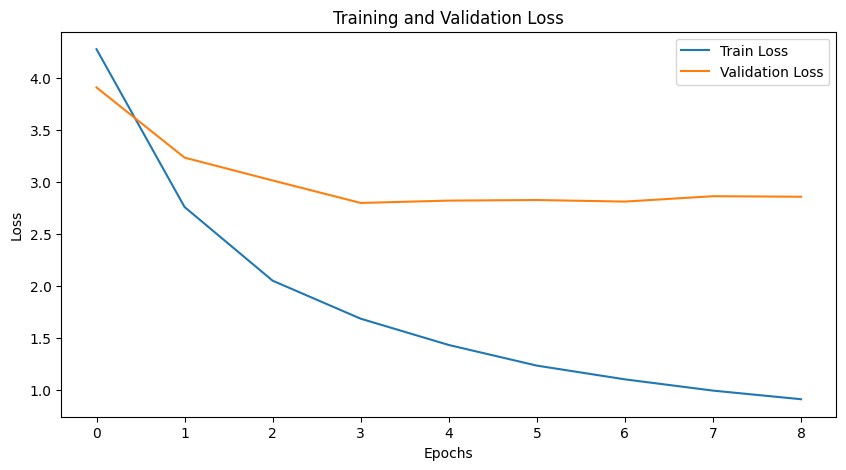

In [11]:
# ==========================================
# VẼ BIỂU ĐỒ LOSS (YÊU CẦU MỤC 11)
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# ==========================================
# 6.4. DỰ ĐOÁN (INFERENCE) - ATTENTION VERSION
# ==========================================
import torch
import os

def translate(sentence: str):
    # Đường dẫn file model
    path_to_model = '/kaggle/working/best_model.pth'
    
    if not os.path.exists(path_to_model):
        return "Lỗi: Chưa có file best_model.pth. Hãy chạy Training trước!"

    # --- LOAD MODEL (Chỉ cần load 1 lần nếu chạy nhiều câu, nhưng để đây cho an toàn) ---
    model.load_state_dict(torch.load(path_to_model, map_location=device))
    model.eval()

    # 1. Xử lý Input (Tokenize & Numericalize)
    if isinstance(sentence, str):
        tokens = tokenize_en(sentence)
        # Chuyển về chữ thường nếu cần (tùy vào cách build vocab)
        tokens = [token.lower() for token in tokens] 
    else:
        tokens = [token.lower() for token in sentence]

    # Thêm <sos> và <eos>
    tokens = ['<sos>'] + tokens + ['<eos>']
    
    # Convert sang index
    src_indexes = [vocab_en[token] for token in tokens]
    
    # Tạo Tensor [src len, 1] (Batch size = 1)
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)])

    # 2. Encoder
    with torch.no_grad():
        # SỬA LỖI Ở ĐÂY: Unpack 3 giá trị thay vì 2
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # 3. Decoder (Greedy Decoding)
    # Khởi tạo input đầu tiên là <sos>
    trg_indexes = [vocab_fr['<sos>']]
    max_len = 50 # Giới hạn độ dài câu dịch

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            # SỬA LỖI Ở ĐÂY: Truyền thêm encoder_outputs vào Decoder
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        # Lấy token có xác suất cao nhất (Greedy)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        # Gặp <eos> thì dừng
        if pred_token == vocab_fr['<eos>']:
            break

    # 4. Convert ids -> text
    trg_tokens = [vocab_fr.lookup_token(i) for i in trg_indexes]

    # Loại bỏ <sos> ở đầu
    result_tokens = trg_tokens[1:]
    
    # Loại bỏ <eos> ở cuối nếu có
    if result_tokens and result_tokens[-1] == '<eos>':
        result_tokens = result_tokens[:-1]

    return " ".join(result_tokens)

# ==========================================
# TEST THỬ NGHIỆM
# ==========================================
# Test 1: Câu đơn giản
sample_1 = "A dog runs in the park" 
print(f"\n[EN]: {sample_1}")
print(f"[FR]: {translate(sample_1)}")

# Test 2: Câu trong tập dữ liệu (Nếu có)
sample_2 = "Two men are talking."
print(f"\n[EN]: {sample_2}")
print(f"[FR]: {translate(sample_2)}")


[EN]: A dog runs in the park
[FR]: Un chien chien court dans le parc

[EN]: Two men are talking.
[FR]: deux hommes parlent .


In [13]:
import torch
from nltk.translate.bleu_score import sentence_bleu
from torchtext.data.metrics import bleu_score

# ==========================================
# 6.5. ĐÁNH GIÁ (EVALUATION & BLEU SCORE) - ĐA BỘ TEST
# ==========================================

# 1. Hàm dịch câu (CẬP NHẬT CHO ATTENTION MODEL)
def translate_sentence(sentence, model, device, max_len=50):
    model.eval()

    # 1. Xử lý Tokenize
    if isinstance(sentence, str):
        tokens = [tok.text.lower() for tok in spacy_en.tokenizer(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 2. Thêm <sos>, <eos> và chuyển thành tensor
    tokens = [vocab_en['<sos>']] + [vocab_en[token] for token in tokens] + [vocab_en['<eos>']]
    
    src_tensor = torch.LongTensor(tokens).unsqueeze(1).to(device) # [src_len, 1]
    src_len = torch.LongTensor([len(tokens)]) # Để ở CPU cho pack_padded_sequence

    # 3. Encoder (SỬA ĐỔI QUAN TRỌNG)
    with torch.no_grad():
        # Attention Encoder trả về 3 giá trị
        encoder_outputs, hidden, cell = model.encoder(src_tensor, src_len)

    # 4. Decoder Loop
    trg_indexes = [vocab_fr['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

        with torch.no_grad():
            # Attention Decoder cần truyền thêm encoder_outputs
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == vocab_fr['<eos>']:
            break

    # 5. Convert id -> Token text
    trg_tokens = [vocab_fr.lookup_token(i) for i in trg_indexes]

    # Trả về list token (bỏ <sos>)
    return trg_tokens[1:]

# 2. Hàm đánh giá một bộ dữ liệu
def evaluate_single_set(model, dataset_name, src_list, trg_list, device, limit=2000):
    """
    Tính BLEU score trung bình cho một tập dữ liệu
    """
    bleu_scores = []
    
    # Giới hạn số mẫu để test nhanh hơn (nếu cần)
    if limit:
        src_eval = src_list[:limit]
        trg_eval = trg_list[:limit]
    else:
        src_eval = src_list
        trg_eval = trg_list

    print(f"--> Đang đánh giá bộ: {dataset_name} (Số mẫu: {len(src_eval)})")

    for i in range(len(src_eval)):
        src = src_eval[i]
        trg = trg_eval[i]

        # A. Dự đoán (Candidate)
        pred_tokens = translate_sentence(src, model, device)
        
        # Loại bỏ <eos> ở cuối nếu có
        if pred_tokens and pred_tokens[-1] == '<eos>':
            pred_tokens = pred_tokens[:-1]

        # B. Thực tế (Reference)
        # Lưu ý: Tokenize reference cũng cần lower để so sánh công bằng
        trg_tokens = [tok.text.lower() for tok in spacy_fr.tokenizer(trg)]

        # C. Tính BLEU
        # sentence_bleu yêu cầu list of references (dạng lồng list) [[tok1, tok2...]]
        score = sentence_bleu([trg_tokens], pred_tokens)
        bleu_scores.append(score)
        
        # Log tiến độ
        if (i + 1) % 500 == 0:
            print(f"    ...Đã xử lý {i + 1} câu.")

    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    print(f"--> Kết quả {dataset_name}: {avg_bleu*100:.2f} BLEU")
    return avg_bleu

# 3. Hàm chạy toàn bộ quy trình (Main Wrapper)
def run_full_evaluation(model, device):
    # Load model tốt nhất
    if not os.path.exists(best_model_path):
        print("Lỗi: Không tìm thấy file model. Hãy train trước!")
        return

    print(f"--> Đang tải model tốt nhất từ {best_model_path}...")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # Định nghĩa các bộ test (Đảm bảo các biến này đã load ở cell Data)
    test_datasets = {
        "Flickr 2016": (test_2016_flickr_en_list, test_2016_flickr_fr_list),
        "Flickr 2017": (test_2017_flickr_en_list, test_2017_flickr_fr_list),
        "Flickr 2018": (test_2018_flickr_en_list, test_2018_flickr_fr_list),
        "MSCOCO 2017": (test_2017_mscoco_en_list, test_2017_mscoco_fr_list)
    }

    all_scores = []

    print(f"\n{'='*50}")
    print(f"BẮT ĐẦU ĐÁNH GIÁ (LIMIT = 2000 MẪU/BỘ)")
    print(f"{'='*50}")

    for name, (src_data, trg_data) in test_datasets.items():
        # Kiểm tra nếu dữ liệu rỗng (tránh lỗi)
        if len(src_data) == 0:
            print(f"Bỏ qua {name} vì không có dữ liệu.")
            continue
            
        score = evaluate_single_set(model, name, src_data, trg_data, device, limit=2000)
        all_scores.append(score)
        print("-" * 30)

    final_avg_bleu = sum(all_scores) / len(all_scores) if all_scores else 0

    print(f"\n{'='*50}")
    print(f"TỔNG HỢP KẾT QUẢ BLEU SCORE")
    print(f"{'='*50}")
    for i, name in enumerate([n for n, d in test_datasets.items() if len(d[0]) > 0]):
        print(f"{name:<15}: {all_scores[i]*100:.2f}")
    
    print("-" * 30)
    print(f"TRUNG BÌNH CHUNG : {final_avg_bleu*100:.2f}")
    print(f"{'='*50}")

# ==========================================
# CHẠY ĐÁNH GIÁ
# ==========================================
run_full_evaluation(model, device)

--> Đang tải model tốt nhất từ /kaggle/working/best_model.pth...

BẮT ĐẦU ĐÁNH GIÁ (LIMIT = 2000 MẪU/BỘ)
--> Đang đánh giá bộ: Flickr 2016 (Số mẫu: 1000)


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2016: 33.50 BLEU
------------------------------
--> Đang đánh giá bộ: Flickr 2017 (Số mẫu: 1000)
    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2017: 25.51 BLEU
------------------------------
--> Đang đánh giá bộ: Flickr 2018 (Số mẫu: 1071)
    ...Đã xử lý 500 câu.
    ...Đã xử lý 1000 câu.
--> Kết quả Flickr 2018: 18.93 BLEU
------------------------------
--> Đang đánh giá bộ: MSCOCO 2017 (Số mẫu: 461)
--> Kết quả MSCOCO 2017: 17.64 BLEU
------------------------------

TỔNG HỢP KẾT QUẢ BLEU SCORE
Flickr 2016    : 33.50
Flickr 2017    : 25.51
Flickr 2018    : 18.93
MSCOCO 2017    : 17.64
------------------------------
TRUNG BÌNH CHUNG : 23.89
